#**EMOTION DETECTION**

In [2]:
import pandas as pd
import numpy as np
import os
import string
import nltk
import re
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from nltk.corpus import stopwords
from google.colab import drive
from transformers import BertForMaskedLM, Trainer, TrainingArguments
from transformers import BertTokenizer, BertForSequenceClassification
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Projek Dosen/Dataset Emosi"
! ls


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Projek Dosen/Dataset Emosi
emotion.csv


In [8]:
df = pd.read_csv("emotion.csv" )

## **EXPLORATORY DATA ANALYST**

In [9]:
df.head()

,text,label
0,pagi2 udah di buat emosi :),Anger
1,"kok stabilitas negara, memange 10 thn negara t...",Anger
2,dah lah emosi mulu liat emyu,Anger
3,"aib? bodoh benar! sebelum kata aib itu muncul,...",Anger
4,dih lu yg nyebelin bego,Anger


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080 entries, 0 to 7079
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7080 non-null   object
 1   label   7080 non-null   object
dtypes: object(2)
memory usage: 110.8+ KB


In [11]:
df.describe()

,text,label
count,7080,7080
unique,7018,6
top,sedih,Neutral
freq,5,2001


In [12]:
df['label'].unique()

array(['Anger', 'Joy', 'Fear', 'Love', 'Neutral', 'Sad'], dtype=object)

In [13]:
df = df[df['label'].isin(['Anger', 'Joy','Fear', 'Neutral', 'Love', 'Sad' ])]

In [14]:
df.value_counts('label')

,count
label,
Neutral,2001
Joy,1275
Anger,1130
Sad,1003
Fear,911
Love,760


<Axes: title={'center': 'words_per_text'}, xlabel='label'>

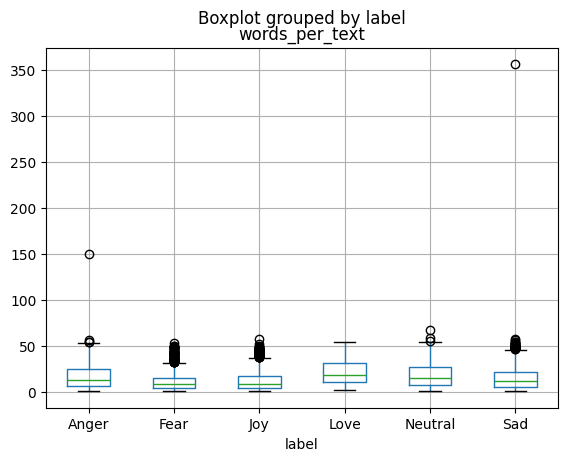

In [15]:
df['words_per_text'] = df['text'].str.split().apply(len)
df.boxplot('words_per_text', by='label')

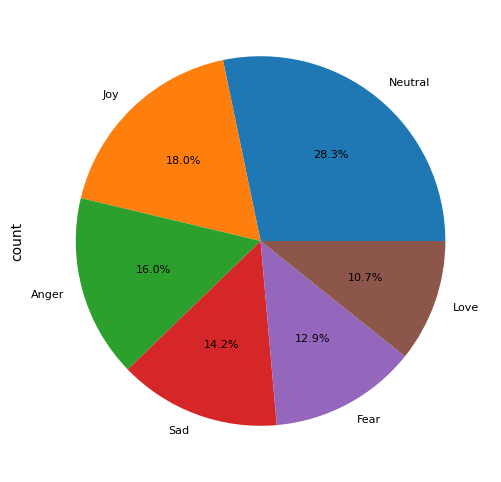

In [16]:
# Mengatur ukuran figure
plt.figure(figsize=(10, 6))

# Membuat pie chart dengan ukuran tulisan yang lebih kecil
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', fontsize=8)

# Menampilkan plot
plt.show()


<ipython-input-17-1781691726>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(label_counts))


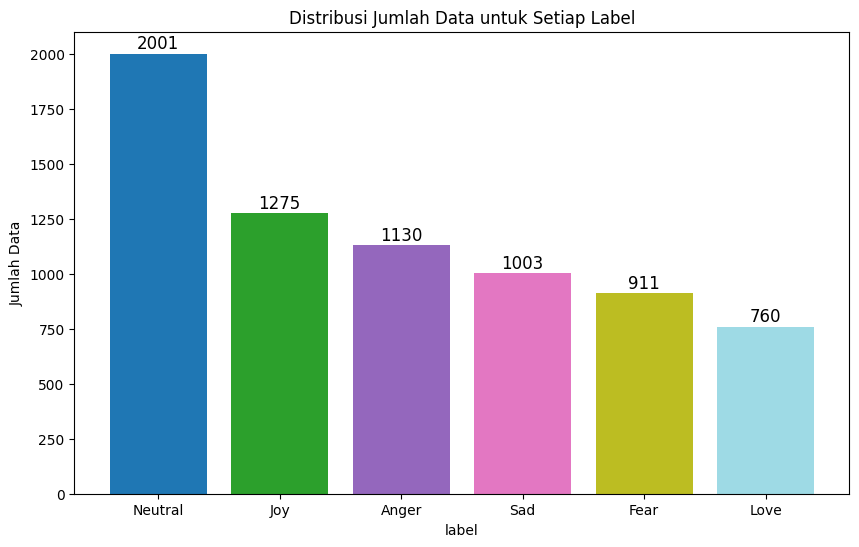

In [17]:
# Menghitung jumlah data untuk setiap label
label_counts = df['label'].value_counts()

# Membuat barchart dengan warna berbeda untuk setiap bar
colors = plt.cm.get_cmap('tab20', len(label_counts))
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=colors(range(len(label_counts))))

# Menambahkan angka pasti di atas setiap bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=12)

# Memberikan label pada sumbu X dan Y
plt.xlabel('label')
plt.ylabel('Jumlah Data')
plt.title('Distribusi Jumlah Data untuk Setiap Label')

# Menampilkan plot
plt.show()


## **PREPROCESSING**

### Balencing Data with SMOTE

In [18]:
# Import library yang dibutuhkan
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch

In [19]:
df
X = df['text']
y = df['label']

In [20]:
df["label"].unique()

array(['Anger', 'Joy', 'Fear', 'Love', 'Neutral', 'Sad'], dtype=object)

In [21]:
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(X)

In [22]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [23]:
smote = SMOTE(k_neighbors=10, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

In [24]:
X_text = vectorizer.inverse_transform(X_resampled)
X_text = [' '.join(tokens) for tokens in X_text]

In [25]:
X

,text
0,pagi2 udah di buat emosi :)
1,"kok stabilitas negara, memange 10 thn negara t..."
2,dah lah emosi mulu liat emyu
3,"aib? bodoh benar! sebelum kata aib itu muncul,..."
4,dih lu yg nyebelin bego
...,...
7075,pagi saat seisi semesta sujud pada zat yg acap...
7076,"meski engkau yg pergi, meski engkau yg meningg..."
7077,udah biasa kalah dan tersakiti
7078,"apakabar ku?. apakah baik-baik saja,, tidak, a..."


In [26]:
print(X_resampled)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 208567 stored elements and shape (12006, 17555)>
  Coords	Values
  (0, 12110)	0.6371073527477105
  (0, 16645)	0.37159736911181906
  (0, 3537)	0.31164184076955065
  (0, 2517)	0.38751721495316604
  (0, 4654)	0.45685817004918117
  (1, 8225)	0.1131425397051685
  (1, 15258)	0.23160481866115215
  (1, 11035)	0.3299307787043128
  (1, 9689)	0.23160481866115215
  (1, 21)	0.1579275346330201
  (1, 16198)	0.19659918841484883
  (1, 15766)	0.15659821589606226
  (1, 671)	0.17475694385995139
  (1, 1297)	0.15032426231302162
  (1, 14114)	0.20846735561023855
  (1, 10283)	0.23160481866115215
  (1, 12019)	0.23160481866115215
  (1, 13400)	0.22136632815705332
  (1, 6494)	0.23160481866115215
  (1, 16052)	0.2141020035380005
  (1, 17426)	0.0760267888985234
  (1, 1719)	0.23160481866115215
  (1, 7409)	0.09865011371897799
  (1, 12248)	0.19997101959845973
  (1, 16107)	0.20846735561023855
  :	:
  (12004, 6452)	0.018154401145151513
  (12004, 14864)	0.014562

In [27]:
X_resampled.shape

(12006, 17555)

In [28]:
y

,label
0,Anger
1,Anger
2,Anger
3,Anger
4,Anger
...,...
7075,Sad
7076,Sad
7077,Sad
7078,Sad


In [29]:
y_resampled

,label
0,Anger
1,Anger
2,Anger
3,Anger
4,Anger
...,...
12001,Sad
12002,Sad
12003,Sad
12004,Sad


In [30]:
class_counts = pd.Series(y_resampled).value_counts()
print(class_counts)

label
Anger      2001
Joy        2001
Fear       2001
Love       2001
Neutral    2001
Sad        2001
Name: count, dtype: int64


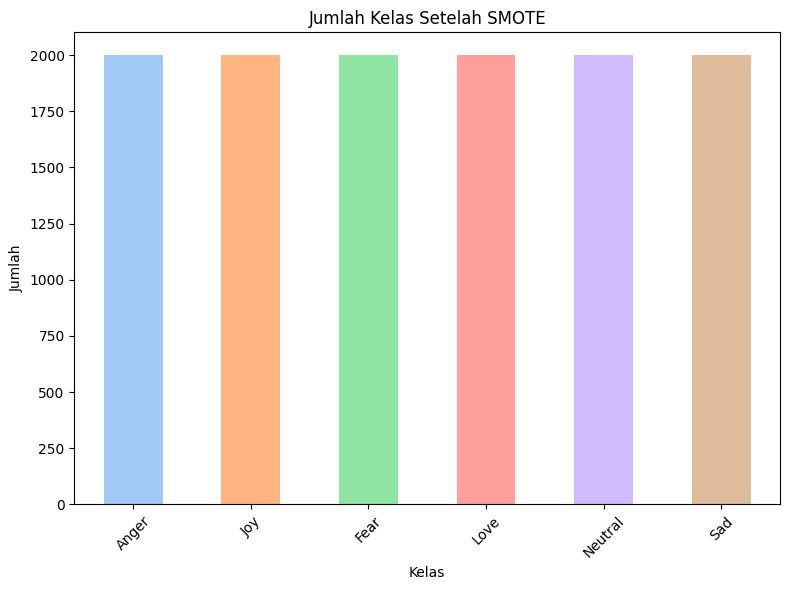

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot bar chart
plt.figure(figsize=(8, 6))
custom_palette = sns.color_palette("pastel")
class_counts.plot(kind='bar', color=custom_palette)
plt.xlabel('Kelas')
plt.ylabel('Jumlah')
plt.title('Jumlah Kelas Setelah SMOTE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
data_resampled = {'text' : X_text,
                'label' : y_resampled}

In [33]:
df_resampled = pd.DataFrame(data_resampled)

In [34]:
df_resampled

,text,label
0,pagi2 udah di buat emosi,Anger
1,kok stabilitas negara memange 10 thn tdk aman ...,Anger
2,emosi dah lah mulu liat emyu,Anger
3,bodoh aib benar sebelum kata itu muncul terleb...,Anger
4,yg dih lu nyebelin bego,Anger
...,...,...
12001,pls sedih banget,Sad
12002,ye hidup gue sepi mentang sabtu amat,Sad
12003,bersedia sedih nungguin tolong banget dan pake...,Sad
12004,inituh sihh ad nya dari bgt indo yg luvies bel...,Sad


In [35]:
def count_term(data):
  count = len(data.split())
  return count

In [36]:
df_resampled['count'] = df_resampled['text'].apply(count_term)

In [37]:
df_resampled[df_resampled["label"]=='Anger']

,text,label,count
0,pagi2 udah di buat emosi,Anger,5
1,kok stabilitas negara memange 10 thn tdk aman ...,Anger,25
2,emosi dah lah mulu liat emyu,Anger,6
3,bodoh aib benar sebelum kata itu muncul terleb...,Anger,36
4,yg dih lu nyebelin bego,Anger,5
...,...,...,...
7946,dhehxhwh kotor ntr nyuci kudu motor amat sendi...,Anger,14
7947,tlong puasa jgn bikin lg pagi aku emosi,Anger,8
7948,masih udah gondok ud mls bkin hadehh ad msh bg...,Anger,14
7949,suka beneran marah allah ya,Anger,5


In [38]:
df_resampled[df_resampled["label"]=='Joy']

,text,label,count
1130,nih enak dipeluk,Joy,3
1131,aku masih bisa klo gk semangat dongg wkkwkwtar...,Joy,10
1132,dan semangat kalian bertambah kuatlah frp_nats...,Joy,8
1133,buat jangan lupa semoga hari semangat ayang sa...,Joy,11
1134,ya ikut semangat seneng aw kuliahnya,Joy,6
...,...,...,...
9762,berak bisa bgt masih ssfw selingannya streamin...,Joy,15
9763,freshh garam anget jugaa air mandi enak langsu...,Joy,36
9764,semangat stad dialah ustadnya anda wkwk jgn su...,Joy,11
9765,mochi total alhamdulillah baby kabar happy dap...,Joy,21


In [39]:
df_resampled[df_resampled["label"]=='Fear']

,text,label,count
2405,buat tp dia aku tolong trs project jujur minta...,Fear,20
2406,ke tp ada aku dan mau ini pengen nangis bgt ba...,Fear,41
2407,buat bisa tu utk beli barang ragu karn hargany...,Fear,11
2408,10 ada sih mana aja banget gua lagi gak bisa g...,Fear,16
2409,yg tp iya suka coba lain wkwk tetep pada takut...,Fear,13
...,...,...,...
9036,ketemuan pointnya aquarius bohong point to pin...,Fear,21
9037,usahakan pokoknya tetap hmm tapi lah bgitu alh...,Fear,24
9038,gaga wkwk grub ngeri kali,Fear,5
9039,richi ibel sebenarnya takut rasa pak tapi ini ...,Fear,10


In [40]:
df_resampled[df_resampled["label"]=='Neutral']

,text,label,count
4076,yang biasa meskipun terlihat pengabdian terpuji,Neutral,6
4077,baru saja foto mengirim,Neutral,4
4078,apa dan dulu twitter dunia kabar masihkah selu...,Neutral,9
4079,di aku sih gimana kita yang dulu sarapan yah y...,Neutral,14
4080,saja beli ka set dorg suro medium,Neutral,7
...,...,...,...
6072,lebih baik karena kuat tau menjadi rasa akan m...,Neutral,13
6073,ada dan yang bukan hanya adalah terbaik karena...,Neutral,17
6074,di yg ada adalah sahabat dengan percaya mereka...,Neutral,17
6075,dia lagi bukan tapi tak karena kamu bisa perca...,Neutral,17


In [41]:
df_resampled[df_resampled["label"]=='Love']

,text,label,count
3316,banget suka hanya saja kata2 kalian menurut se...,Love,9
3317,itu anak pake aku sih gini aja terus banget su...,Love,29
3318,aja ya kali suka kadang cinta telat ngejar tah...,Love,9
3319,juga dia sama aku dan terus nanti balik ya pag...,Love,33
3320,di itu ada anak juga aku dan banget event sana...,Love,24
...,...,...,...
11003,downsizing fav least pc sedih mulai karna bing...,Love,15
11004,2k ratusan ongkirnya toko jutaan harga ijo ttp...,Love,15
11005,nyaman cintai end bgtt then ngerasa jadi lebih...,Love,46
11006,minhyun cantik ultah foto masi deh suka banget...,Love,12


In [42]:
df_resampled[df_resampled["label"]=='Sad']

,text,label,count
6077,tp dah anak dan sampe dulu tidak bangun dari k...,Sad,28
6078,sepi,Sad,1
6079,dah sedih,Sad,2
6080,ada sm pengen kalo ga main waktu jg temen emg ...,Sad,14
6081,ya bener sedih club niih,Sad,5
...,...,...,...
12001,pls sedih banget,Sad,3
12002,ye hidup gue sepi mentang sabtu amat,Sad,7
12003,bersedia sedih nungguin tolong banget dan pake...,Sad,15
12004,inituh sihh ad nya dari bgt indo yg luvies bel...,Sad,22


In [43]:
df_resampled['length'] = df_resampled['text'].apply(lambda x: len(x))

In [44]:
df_resampled[df_resampled['length']<1]

,text,label,count,length


In [45]:
df_resampled = df_resampled[df_resampled['length']>1]
df_resampled = df_resampled.reset_index(drop=True)

In [46]:
df_resampled[df_resampled.duplicated()].sort_values(by=['text'])
df_resampled.head(3000)

,text,label,count,length
0,pagi2 udah di buat emosi,Anger,5,24
1,kok stabilitas negara memange 10 thn tdk aman ...,Anger,25,169
2,emosi dah lah mulu liat emyu,Anger,6,28
3,bodoh aib benar sebelum kata itu muncul terleb...,Anger,36,250
4,yg dih lu nyebelin bego,Anger,5,23
...,...,...,...,...
2995,di dah liat malu rep gue dulu jgn untung plis ...,Fear,11,50
2996,malu sih gw klo digituin,Fear,5,24
2997,aku ayam ko yakin mie ragu ilangin,Fear,7,34
2998,sendiri bisa kaget langsung keluar bisanya teb...,Fear,10,68


In [47]:
temp = df_resampled.groupby('label').count()['text'].reset_index()
temp.style.background_gradient(cmap='Blues')

,label,text
0,Anger,2001
1,Fear,2001
2,Joy,2001
3,Love,2001
4,Neutral,2001
5,Sad,2001


In [48]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

In [49]:
df_resampled['label'] = label_encoder.fit_transform(df_resampled['label'])

In [50]:
df_resampled[df_resampled['label']==0]

,text,label,count,length
0,pagi2 udah di buat emosi,0,5,24
1,kok stabilitas negara memange 10 thn tdk aman ...,0,25,169
2,emosi dah lah mulu liat emyu,0,6,28
3,bodoh aib benar sebelum kata itu muncul terleb...,0,36,250
4,yg dih lu nyebelin bego,0,5,23
...,...,...,...,...
7946,dhehxhwh kotor ntr nyuci kudu motor amat sendi...,0,14,80
7947,tlong puasa jgn bikin lg pagi aku emosi,0,8,39
7948,masih udah gondok ud mls bkin hadehh ad msh bg...,0,14,65
7949,suka beneran marah allah ya,0,5,27


In [51]:
df_resampled.head(3000)

,text,label,count,length
0,pagi2 udah di buat emosi,0,5,24
1,kok stabilitas negara memange 10 thn tdk aman ...,0,25,169
2,emosi dah lah mulu liat emyu,0,6,28
3,bodoh aib benar sebelum kata itu muncul terleb...,0,36,250
4,yg dih lu nyebelin bego,0,5,23
...,...,...,...,...
2995,di dah liat malu rep gue dulu jgn untung plis ...,1,11,50
2996,malu sih gw klo digituin,1,5,24
2997,aku ayam ko yakin mie ragu ilangin,1,7,34
2998,sendiri bisa kaget langsung keluar bisanya teb...,1,10,68


In [52]:
data = df_resampled.copy()
data.head(3000)

,text,label,count,length
0,pagi2 udah di buat emosi,0,5,24
1,kok stabilitas negara memange 10 thn tdk aman ...,0,25,169
2,emosi dah lah mulu liat emyu,0,6,28
3,bodoh aib benar sebelum kata itu muncul terleb...,0,36,250
4,yg dih lu nyebelin bego,0,5,23
...,...,...,...,...
2995,di dah liat malu rep gue dulu jgn untung plis ...,1,11,50
2996,malu sih gw klo digituin,1,5,24
2997,aku ayam ko yakin mie ragu ilangin,1,7,34
2998,sendiri bisa kaget langsung keluar bisanya teb...,1,10,68


In [53]:
# Hapus kolom count dan lengtth
data.drop(columns=['count','length'], inplace=True)
data.head(3000)

,text,label
0,pagi2 udah di buat emosi,0
1,kok stabilitas negara memange 10 thn tdk aman ...,0
2,emosi dah lah mulu liat emyu,0
3,bodoh aib benar sebelum kata itu muncul terleb...,0
4,yg dih lu nyebelin bego,0
...,...,...
2995,di dah liat malu rep gue dulu jgn untung plis ...,1
2996,malu sih gw klo digituin,1
2997,aku ayam ko yakin mie ragu ilangin,1
2998,sendiri bisa kaget langsung keluar bisanya teb...,1


In [54]:
data.shape

(12006, 2)

In [55]:
data = data.reset_index(drop=True)

In [56]:
data["label"].unique()

array([0, 2, 1, 3, 4, 5])

In [57]:
# mengganti label 0, 1, 2, 3, 4, 5 menjadi text
data['label'] = data['label'].replace({0: 'Anger', 1: 'Joy', 2: 'Fear', 3: 'Neutral', 4: 'Love', 5: 'sad'})

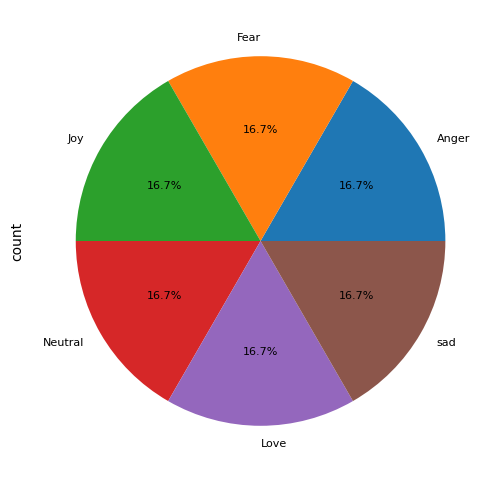

In [58]:
# Mengatur ukuran figure
plt.figure(figsize=(10, 6))

# Membuat pie chart dengan ukuran tulisan yang lebih kecil
data['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', fontsize=8)

# Menampilkan plot
plt.show()

In [59]:
data.dropna(inplace = True)

In [60]:
data.head()

,text,label
0,pagi2 udah di buat emosi,Anger
1,kok stabilitas negara memange 10 thn tdk aman ...,Anger
2,emosi dah lah mulu liat emyu,Anger
3,bodoh aib benar sebelum kata itu muncul terleb...,Anger
4,yg dih lu nyebelin bego,Anger


In [61]:
df = data.copy()
df.head()

,text,label
0,pagi2 udah di buat emosi,Anger
1,kok stabilitas negara memange 10 thn tdk aman ...,Anger
2,emosi dah lah mulu liat emyu,Anger
3,bodoh aib benar sebelum kata itu muncul terleb...,Anger
4,yg dih lu nyebelin bego,Anger


### Lowercase

In [62]:
def lowercase_text(df, column_name):
    df[column_name] = df[column_name].str.lower()
    return df

df = lowercase_text(df, 'text')
df = lowercase_text(df, 'label')
df.head(10)

,text,label
0,pagi2 udah di buat emosi,anger
1,kok stabilitas negara memange 10 thn tdk aman ...,anger
2,emosi dah lah mulu liat emyu,anger
3,bodoh aib benar sebelum kata itu muncul terleb...,anger
4,yg dih lu nyebelin bego,anger
5,yg ada asli malu maluin org indo tolol rep lat...,anger
6,tolol drama abg,anger
7,emosi sama masih sih katla kemarin mana ketera...,anger
8,bangsat tribute no bencana mau ngalahin ini ke...,anger
9,udah tolol pengen pergi jauh terus teriak samb...,anger


### Remove Punctuation

In [63]:
def remove_punctuation(df, column_name):
    df[column_name] = df[column_name].str.translate(str.maketrans('', '', string.punctuation))
    return df

df = remove_punctuation(df, 'text')

In [64]:
df.tail(10)

,text,label
11996,monday turut allah kadg mnurut mngkin ambisnya...,sad
11997,amehnya twitt komen2 menikmati isinya membaca ...,sad
11998,disini nangissss filmnya bgtttt sepi bener2 no...,sad
11999,dihitung bantu terima beberapa kasih lihat seg...,sad
12000,relation taktahu mv omg besar lagu tahu dengar...,sad
12001,pls sedih banget,sad
12002,ye hidup gue sepi mentang sabtu amat,sad
12003,bersedia sedih nungguin tolong banget dan pake...,sad
12004,inituh sihh ad nya dari bgt indo yg luvies bel...,sad
12005,penonton kecewa yah,sad


### Remove Numbers & Extra WhiteSpace

In [65]:
def remove_numbers_and_extra_whitespace(df, column_name):
    # Menghapus angka
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'\d+', '', x))

    # Menghapus spasi berlebih
    df[column_name] = df[column_name].apply(lambda x: ' '.join(x.split()))

    return df

df = remove_numbers_and_extra_whitespace(df, 'text')


### Remove user handles

In [66]:
!pip install NeatText

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 4.4 MB/s eta 0:00:00


In [67]:
import neattext.functions as nfx

df['text'].apply(nfx.remove_userhandles)

,text
0,pagi udah di buat emosi
1,kok stabilitas negara memange thn tdk aman bah...
2,emosi dah lah mulu liat emyu
3,bodoh aib benar sebelum kata itu muncul terleb...
4,yg dih lu nyebelin bego
...,...
12001,pls sedih banget
12002,ye hidup gue sepi mentang sabtu amat
12003,bersedia sedih nungguin tolong banget dan pake...
12004,inituh sihh ad nya dari bgt indo yg luvies bel...


In [68]:
dir(nfx)

['BTC_ADDRESS_REGEX',
 'CURRENCY_REGEX',
 'CURRENCY_SYMB_REGEX',
 'Counter',
 'DATE_REGEX',
 'EMAIL_REGEX',
 'EMOJI_REGEX',
 'HASTAG_REGEX',
 'MASTERCard_REGEX',
 'MD5_SHA_REGEX',
 'MOST_COMMON_PUNCT_REGEX',
 'NUMBERS_REGEX',
 'PHONE_REGEX',
 'PoBOX_REGEX',
 'SPECIAL_CHARACTERS_REGEX',
 'STOPWORDS',
 'STOPWORDS_de',
 'STOPWORDS_en',
 'STOPWORDS_es',
 'STOPWORDS_fr',
 'STOPWORDS_ru',
 'STOPWORDS_yo',
 'STREET_ADDRESS_REGEX',
 'TextFrame',
 'URL_PATTERN',
 'USER_HANDLES_REGEX',
 'VISACard_REGEX',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__generate_text',
 '__loader__',
 '__name__',
 '__numbers_dict',
 '__package__',
 '__spec__',
 '_lex_richness_herdan',
 '_lex_richness_maas_ttr',
 'clean_text',
 'defaultdict',
 'digit2words',
 'extract_btc_address',
 'extract_currencies',
 'extract_currency_symbols',
 'extract_dates',
 'extract_emails',
 'extract_emojis',
 'extract_hashtags',
 'extract_html_tags',
 'extract_mastercard_addr',
 'extract_md5sha',
 'extract_numbers',
 'extr

In [69]:
df.tail(10)

,text,label
11996,monday turut allah kadg mnurut mngkin ambisnya...,sad
11997,amehnya twitt komen menikmati isinya membaca i...,sad
11998,disini nangissss filmnya bgtttt sepi bener non...,sad
11999,dihitung bantu terima beberapa kasih lihat seg...,sad
12000,relation taktahu mv omg besar lagu tahu dengar...,sad
12001,pls sedih banget,sad
12002,ye hidup gue sepi mentang sabtu amat,sad
12003,bersedia sedih nungguin tolong banget dan pake...,sad
12004,inituh sihh ad nya dari bgt indo yg luvies bel...,sad
12005,penonton kecewa yah,sad


### Remove Stopwords

In [70]:
def remove_stopwords(df, column_name, language='indonesian'):
    stop_words = set(stopwords.words(language))
    df[column_name] = df[column_name].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    return df

df = remove_stopwords(df, 'text')

In [71]:
df.head(10)

,text,label
0,pagi udah emosi,anger
1,stabilitas negara memange thn tdk aman sby men...,anger
2,emosi dah mulu liat emyu,anger
3,bodoh aib muncul tindakan kekejian kau sembuny...,anger
4,yg dih lu nyebelin bego,anger
5,yg asli malu maluin org indo tolol rep latah c...,anger
6,tolol drama abg,anger
7,emosi sih katla kemarin keterangannya gini aja...,anger
8,bangsat tribute no bencana ngalahin keknya,anger
9,udah tolol pengen pergi teriak nangis sekencan...,anger


### Text to Tokens Conversion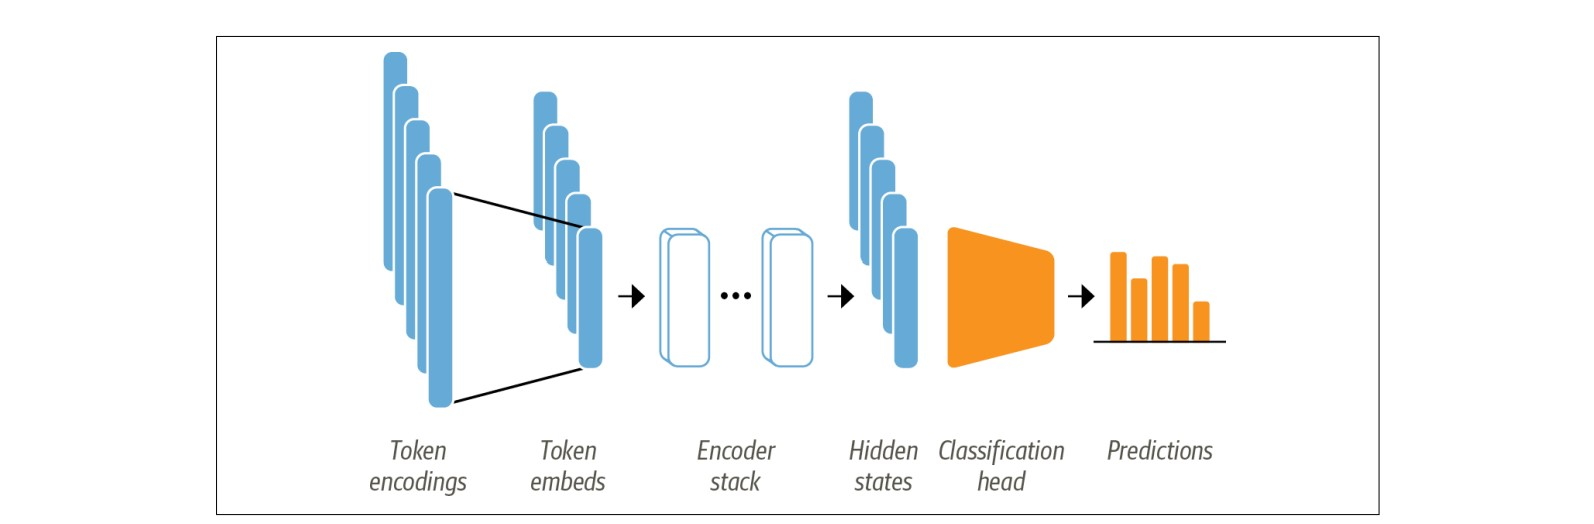

In [73]:
from transformers import BertTokenizer

def tokenize_with_bert(df, column_name):
    # Load pre-trained BERT tokenizer (cased version)
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

    # Kumpulkan semua kata unik dari teks untuk menambahkan ke vocabulary
    unique_words = set()
    for text in df[column_name]:
        words = text.split()
        unique_words.update(words)

    # Pilih kata yang tidak ada di tokenizer vocabulary
    new_tokens = [word for word in unique_words if word not in tokenizer.get_vocab()]

    # Tambahkan kata baru ke tokenizer
    tokenizer.add_tokens(new_tokens)

    # Tokenisasi teks dengan tokenizer yang diperbarui
    df[column_name + '_tokenized'] = df[column_name].apply(lambda x: tokenizer.tokenize(str(x)))

    return df, tokenizer  # Return dataframe dan tokenizer yang telah diperbarui

# Contoh penggunaan fungsi
df, tokenizer = tokenize_with_bert(df, 'text')


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Stemming

In [74]:
!pip install PySastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 7.0 MB/s eta 0:00:00


In [75]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming_tokens(df, column_name):

    def stem_sentence(tokens):
        return [stemmer.stem(token) for token in tokens]

    df[column_name + '_stemmed'] = df[column_name].apply(stem_sentence)
    return df

# Contoh penggunaan fungsi
df = stemming_tokens(df, 'text_tokenized')


In [76]:
df.head(10)

,text,label,text_tokenized,text_tokenized_stemmed
0,pagi udah emosi,anger,"[pagi, udah, emosi]","[pagi, udah, emosi]"
1,stabilitas negara memange thn tdk aman sby men...,anger,"[stabilitas, negara, memange, thn, tdk, aman, ...","[stabilitas, negara, memange, thn, tdk, aman, ..."
2,emosi dah mulu liat emyu,anger,"[emosi, dah, mulu, liat, emyu]","[emosi, dah, mulu, liat, emyu]"
3,bodoh aib muncul tindakan kekejian kau sembuny...,anger,"[bodoh, aib, muncul, tindakan, kekejian, kau, ...","[bodoh, aib, muncul, tindak, keji, kau, sembun..."
4,yg dih lu nyebelin bego,anger,"[yg, dih, lu, nyebelin, bego]","[yg, dih, lu, nyebelin, bego]"
5,yg asli malu maluin org indo tolol rep latah c...,anger,"[yg, asli, malu, maluin, o, rg, indo, tolol, r...","[yg, asli, malu, maluin, o, rg, indo, tolol, r..."
6,tolol drama abg,anger,"[tolol, dra, ma, abg]","[tolol, dra, ma, abg]"
7,emosi sih katla kemarin keterangannya gini aja...,anger,"[emosi, sih, katla, kemarin, keterangannya, gi...","[emosi, sih, katla, kemarin, terang, gin, aja,..."
8,bangsat tribute no bencana ngalahin keknya,anger,"[bangsat, tri, bu, te, no, bencana, ngalahin, ...","[bangsat, tri, bu, te, no, bencana, ngalahin, ..."
9,udah tolol pengen pergi teriak nangis sekencan...,anger,"[udah, tolol, pengen, pergi, teriak, nangis, s...","[udah, tolol, ken, pergi, teriak, nang, kencan..."


## **PROCESSING**

###Save Dataset After Preprocessing

In [77]:
# Ambil Text yang sudah di proses dan Label saja
df = df[['text_tokenized_stemmed', 'label']]
df.head(10)

,text_tokenized_stemmed,label
0,"[pagi, udah, emosi]",anger
1,"[stabilitas, negara, memange, thn, tdk, aman, ...",anger
2,"[emosi, dah, mulu, liat, emyu]",anger
3,"[bodoh, aib, muncul, tindak, keji, kau, sembun...",anger
4,"[yg, dih, lu, nyebelin, bego]",anger
5,"[yg, asli, malu, maluin, o, rg, indo, tolol, r...",anger
6,"[tolol, dra, ma, abg]",anger
7,"[emosi, sih, katla, kemarin, terang, gin, aja,...",anger
8,"[bangsat, tri, bu, te, no, bencana, ngalahin, ...",anger
9,"[udah, tolol, ken, pergi, teriak, nang, kencan...",anger


In [78]:
df.rename(columns={'text_tokenized_stemmed': 'text'}, inplace=True)
df.head()

<ipython-input-78-2181613519>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'text_tokenized_stemmed': 'text'}, inplace=True)


,text,label
0,"[pagi, udah, emosi]",anger
1,"[stabilitas, negara, memange, thn, tdk, aman, ...",anger
2,"[emosi, dah, mulu, liat, emyu]",anger
3,"[bodoh, aib, muncul, tindak, keji, kau, sembun...",anger
4,"[yg, dih, lu, nyebelin, bego]",anger


In [79]:
df.to_csv('dataPreprocessingBert.csv', index=False)

### Label Encoder

In [80]:
df = pd.read_csv("dataPreprocessingBert.csv")

In [81]:
df.head()

,text,label
0,"['pagi', 'udah', 'emosi']",anger
1,"['stabilitas', 'negara', 'memange', 'thn', 'td...",anger
2,"['emosi', 'dah', 'mulu', 'liat', 'emyu']",anger
3,"['bodoh', 'aib', 'muncul', 'tindak', 'keji', '...",anger
4,"['yg', 'dih', 'lu', 'nyebelin', 'bego']",anger


In [82]:
# Mapping manual dari string ke integer
label_mapping = {
    'anger': 0,
    'joy': 1,
    'fear': 2,
    'neutral': 3,
    'love': 4,
    'sad': 5,
}

# Konversi label string ke integer menggunakan mapping
df['label'] = df['label'].map(label_mapping)


### Split Train Test Data

In [83]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9604,)
X_test shape: (2402,)
y_train shape: (9604,)
y_test shape: (2402,)


**FINE TUNING TRANSFORMERS**

### Modelling

In [84]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased') # diganti bert-base-cased
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=6) # diganti bert-base-cased

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
#
class EmotionsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

#
train_dataset = EmotionsDataset(train_encodings, y_train.tolist())
test_dataset = EmotionsDataset(test_encodings, y_test.tolist())

In [86]:
#
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy, "f1": f1}

In [87]:
from transformers import Trainer, TrainingArguments

In [88]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    report_to="none"
)

#
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=6) # disini diganti bert-base-cased

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [89]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

#
trainer.train()

#
results = trainer.evaluate()
print(results)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.929400,0.944789,0.710241,0.701219
2,0.841600,0.860055,0.718152,0.696836
3,0.685200,0.708188,0.767277,0.754518
4,0.505300,0.791017,0.771857,0.763782
5,0.446100,0.757182,0.794338,0.797741
6,0.359800,0.924303,0.784763,0.781439
7,0.216900,1.133935,0.789342,0.777075
8,0.137100,1.181683,0.807660,0.804999
9,0.079000,1.258219,0.811823,0.807869
10,0.061800,1.272358,0.812656,0.810106


{'eval_loss': 1.2723582983016968, 'eval_accuracy': 0.8126561199000832, 'eval_f1': 0.8101064233396874, 'eval_runtime': 18.0687, 'eval_samples_per_second': 132.937, 'eval_steps_per_second': 16.659, 'epoch': 10.0}


In [90]:
trainer.evaluate()

{'eval_loss': 1.2723582983016968,
 'eval_accuracy': 0.8126561199000832,
 'eval_f1': 0.8101064233396874,
 'eval_runtime': 18.2462,
 'eval_samples_per_second': 131.644,
 'eval_steps_per_second': 16.497,
 'epoch': 10.0}

In [91]:
labels_list = ['Anger', 'Fear', 'Joy', 'Love', 'Neutral', 'Sad']  # Define labels_list

In [92]:
# Use the trained 'trainer' to make predictions on the 'test_dataset'.
outputs = trainer.predict(test_dataset)

# Print the metrics obtained from the prediction outputs.
print(outputs.metrics)

{'test_loss': 1.2723582983016968, 'test_accuracy': 0.8126561199000832, 'test_f1': 0.8101064233396874, 'test_runtime': 18.3453, 'test_samples_per_second': 130.933, 'test_steps_per_second': 16.408}


Accuracy: 0.8127
F1 Score: 0.8115


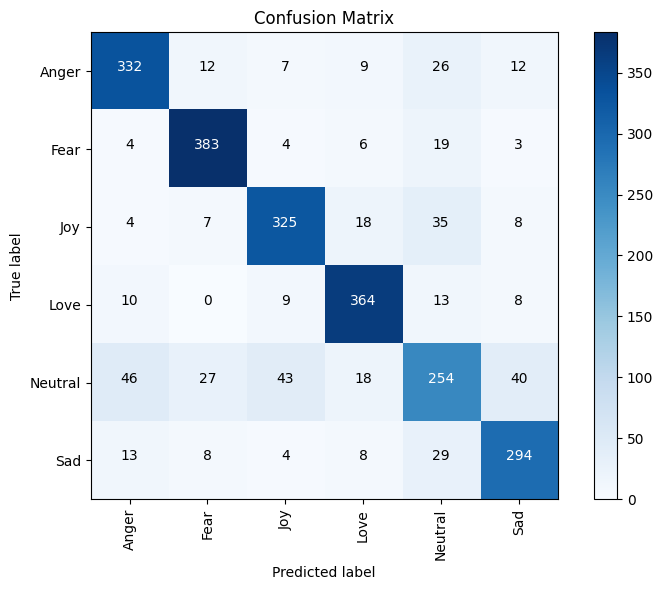


Classification report:

              precision    recall  f1-score   support

       Anger     0.8117    0.8342    0.8228       398
        Fear     0.8764    0.9141    0.8949       419
         Joy     0.8291    0.8186    0.8238       397
        Love     0.8605    0.9010    0.8803       404
     Neutral     0.6755    0.5935    0.6318       428
         Sad     0.8055    0.8258    0.8155       356

    accuracy                         0.8127      2402
   macro avg     0.8098    0.8145    0.8115      2402
weighted avg     0.8089    0.8127    0.8101      2402



In [93]:
from sklearn.metrics import confusion_matrix
import itertools
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a relatively small number of labels
if len(labels_list) <= 120:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

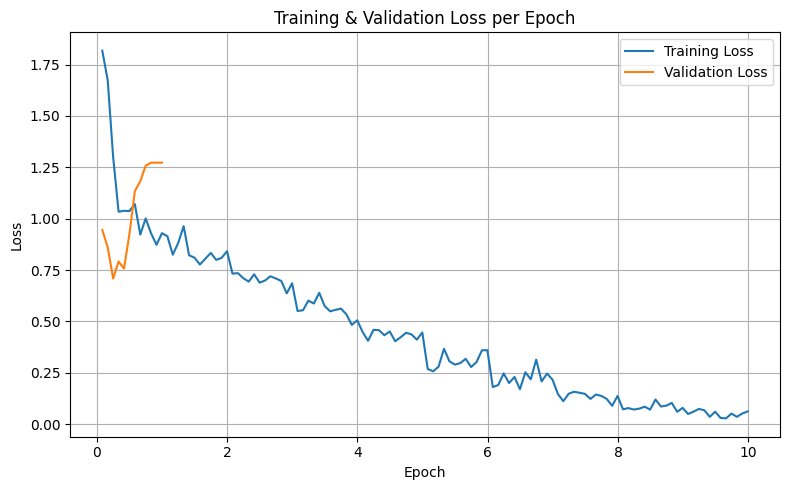

In [94]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history

train_loss = []
eval_loss = []
epochs = []

for log in log_history:
    if 'loss' in log and 'epoch' in log:
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])
    elif 'eval_loss' in log and 'epoch' in log:
        eval_loss.append(log['eval_loss'])

plt.figure(figsize=(8, 5))
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
plt.plot(epochs[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
